# Introduction to sklearn-onnx


Convert [scikit-learn](https://scikit-learn.org/stable/) models into ONNX.

**scikit-learn** is a few words.

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
clr = RandomForestClassifier()
clr.fit(X_train, y_train)

RandomForestClassifier()

In [2]:
clr.predict(X_test)

array([1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 1, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 2,
       2, 0, 2, 1, 0, 2, 2, 1, 0, 2, 0, 0, 0, 2, 1, 0])

In [3]:
import numpy as np
from skl2onnx import to_onnx
clr_onnx = to_onnx(clr, X_train.astype(np.float32))

**Part 1 : convert to ONNX**

* [scikit-learn](https://scikit-learn.org/) design, [sklearn-onnx](https://onnx.ai/sklearn-onnx/) design
* Options (black list, white list)
* double, float, sparse

**Part 2 : Custom operators and API**

* Initial API: verbose
* Second API: much more readable
* Numpy API: python users

**Part 3 : Challenges and tools**

* The missing converter: FunctionTransformer
* Python Runtime for ONNX
* Writing mathematical function with ONNX such as FFT2D

In [4]:
from jyquickhelper import add_notebook_menu
from IPython.display import Image
add_notebook_menu()

## Part 1: convert to ONNX


* [scikit-learn](https://scikit-learn.org/) design, [sklearn-onnx](https://onnx.ai/sklearn-onnx/) design
    * simple example
    * ``fit``, ``predict``, ``pipelines``
    * parser, shape calculator, converter
    * package folders
* Options (black list, white list)
    * One opset, one ONNX graph
    * Use custom optimized operator (CDist, Tokenizer)
    * Black list an operator
    * Zipmap
* double, float, sparse
    * scikit-learn, lightgbm are using double, onnx does not support double for all operators
    * cannot replace double by float --> unavoidable discrepancies
    * scikit-learn is using dense and sparse ([OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [TfIdfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html))

In [5]:
add_notebook_menu(first_level=2, keep_item=0)

### scikit-learn design: fit, predict, pipelines


In [6]:
import warnings
from pandas import DataFrame
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

data = load_boston()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y)

dft = DataFrame(X_train, columns=data.feature_names)
dft['Y'] = y_train
dft.head(n=2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Y
0,1.42502,0.0,19.58,0.0,0.871,6.510,100.0,1.7659,5.0,403.0,14.7,364.31,7.39,23.3
1,13.35980,0.0,18.10,0.0,0.693,5.887,94.7,1.7821,24.0,666.0,20.2,396.90,16.35,12.7


The model:
* Normalizes a few continuous columns
* Transforms two columns with categories
* Merges all and trains a linear predictor

**Training**

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

model = Pipeline(steps=[
    ('prep', ColumnTransformer([
        ('scaler', StandardScaler(), [0, 2, 4, 5, 6]),
        ('cat', OneHotEncoder(), [3, 8]),
    ])),
    ('reg', LinearRegression())
])
model.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  [0, 2, 4, 5, 6]),
                                                 ('cat', OneHotEncoder(),
                                                  [3, 8])])),
                ('reg', LinearRegression())])

**Prediction**

It calls method ``predict`` for each component of the pipeline

In [8]:
model.predict(X_test)[:3]

array([23.03346535, 17.35208074, 18.89496436])

**Visualization**

In [9]:
from jyquickhelper import RenderJsDot
from mlinsights.plotting import pipeline2dot
dot = pipeline2dot(model, X_train)
RenderJsDot(dot, height="40%", width="40%")

### sklearn-onnx: parser, shape calculator, converter

The conversion happens with one function: [to_onnx](https://onnx.ai/sklearn-onnx/api_summary.html#skl2onnx.to_onnx). It runs:
* the **parsers**: extract the **number of outputs** of every step in the pipeline
* the **shape calculators**: compute the **shapes** of every step in the pipeline
* the converters: **convert** every step in the pipeline and an equivalent ONNX graph

In [10]:
from skl2onnx import to_onnx
from skl2onnx.common.data_types import DoubleTensorType

model_onnx = to_onnx(model, X_train.astype(np.float64))

print(str(model_onnx)[:400])

ir_version: 7
producer_name: "skl2onnx"
producer_version: "1.9.4.dev"
domain: "ai.onnx"
model_version: 0
doc_string: ""
graph {
  node {
    input: "X"
    input: "column_indices"
    output: "extracted_feature_columns"
    name: "ArrayFeatureExtractor"
    op_type: "ArrayFeatureExtractor"
    domain: "ai.onnx.ml"
  }
  node {
    input: "X"
    input: "column_indices1"
    output: "extracted_feat


**Visualization**

In [11]:
%load_ext mlprodict

In [12]:
%onnxview model_onnx --size="8%"

**parser**

0. The main parser calls the parser for the pipeline.
1. The pipeline parser calls the parser of every step.
2. The pipeline of step 1 (ColumnTransformer) calls the parser of every step included in it (recursively).

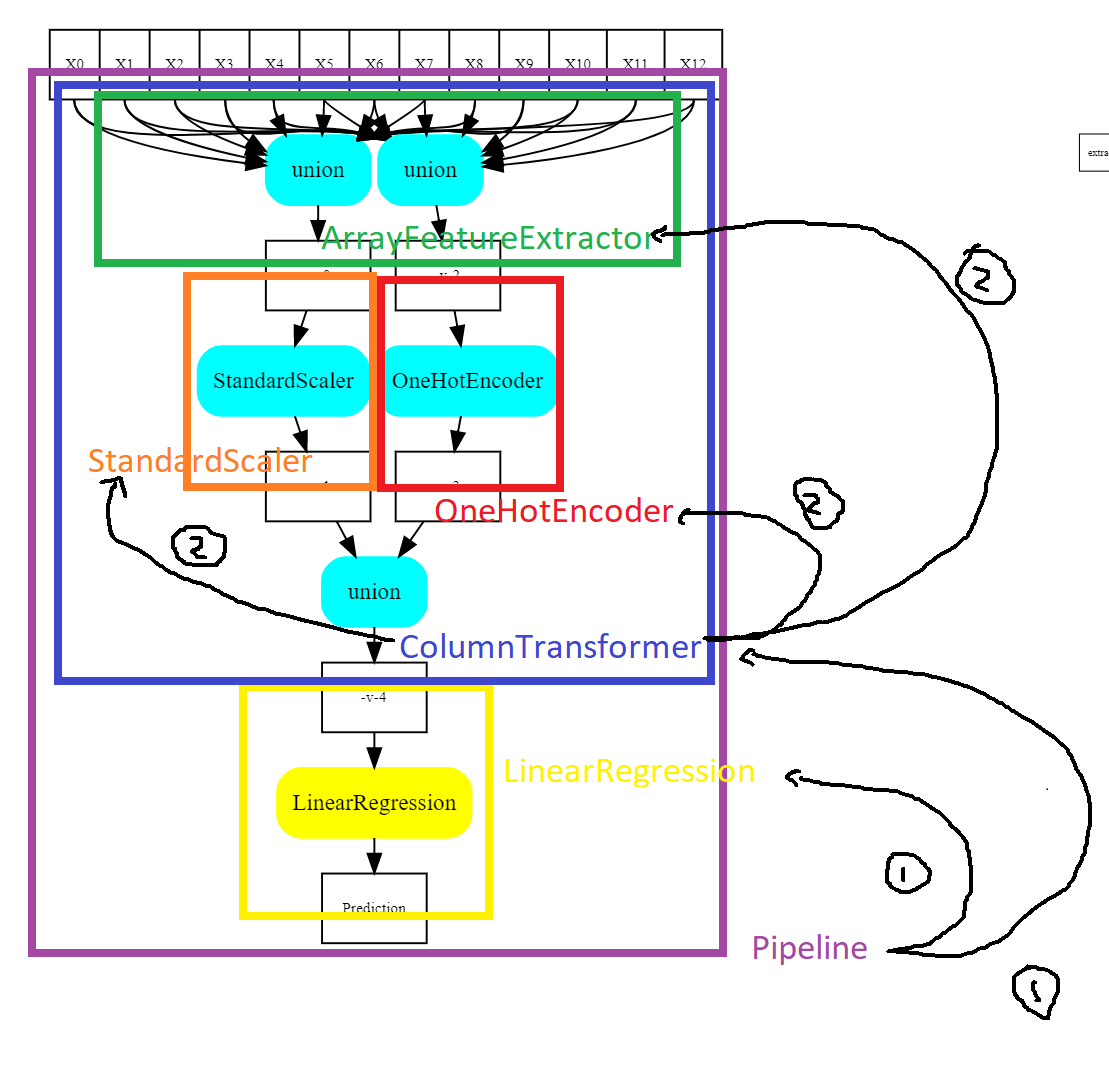

In [13]:
Image('images/pipeskl.png', width=500)

**parser signature**

* Creates an instance of class [Operator](https://onnx.ai/sklearn-onnx/api_summary.html#skl2onnx.common._topology.Operator)
* Fills with [Variable](https://onnx.ai/sklearn-onnx/api_summary.html#skl2onnx.common._topology.Variable) as inputs
* Creates expected output [Variable](https://onnx.ai/sklearn-onnx/api_summary.html#skl2onnx.common._topology.Variable) as outputs
* Returns the outputs (= inputs for next steps)

In [14]:
def parser_example(
        scope,  # namespace (avoids creating duplicating names)
        model, # any scikit-learn model,
        inputs, # known inputs (Variable)
        custom_parsers=None): # custom parser

    step_to_convert = scope.declare_local_operator(alias, model)

    # inputs
    step_to_convert.inputs.append(inputs[0])

    # outputs
    out1 = scope.declare_local_variable('prediction', FloatTensorType())
    step_to_convert.outputs.append(out1)

    # ends
    return step_to_convert.outputs

**Result after parsing**

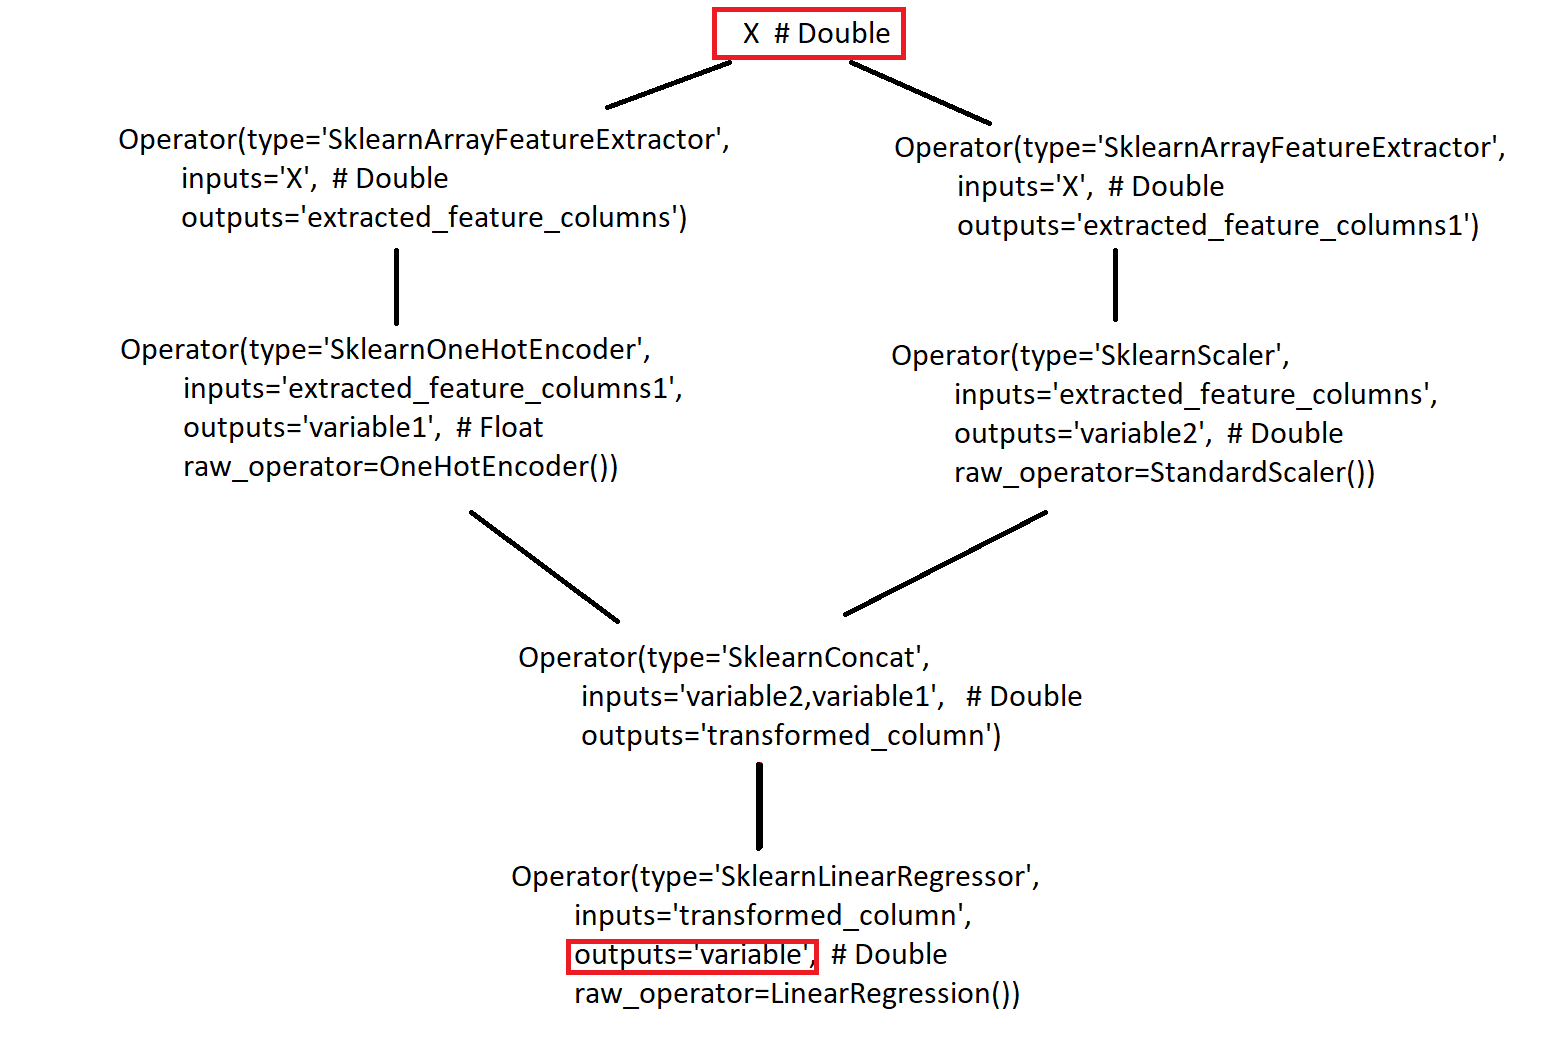

In [15]:
Image('images/op2onx.png', width=800)

**How many parsers?**

* One for each kind of machine learning problem (regressor, classifier, clustering)
* One for each pipeline manipulations ([Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), [UnionFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html).
* One for each model with an option to add more results ('score_samples' in [GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture.score_samples))
* One main parser to dispatch the calls.

### Topology

Once the parsing is done. The topology handles the conversion of every `Operator`.

The loop: [convert_topology](https://github.com/onnx/sklearn-onnx/blob/master/skl2onnx/common/_topology.py#L1067).

* Function [to_onnx](http://onnx.ai/sklearn-onnx/api_summary.html#skl2onnx.to_onnx) creates a [Topology](http://onnx.ai/sklearn-onnx/api_summary.html#skl2onnx.common._topology.Topology)
* **Iteration 1:** The topology calls shape calculator, converter.
* **Iteration 2:** The converters may declare new operators, they call the parsers (recursively). Return to **iteration 1** until there is no new operator.

**shape calculator signature**

The shape calculator estimates the output size. It can be left unknown if this size cannot be fully inferred (rare): ``FloatTensorType([None, None])``.

example: [KMeans](https://github.com/onnx/sklearn-onnx/blob/master/skl2onnx/shape_calculators/k_means.py)

In [16]:
def shape_calculator_example(operator):
    op = operator.raw_operator  # the scikit-learn model
    input_type = operator.inputs[0].type.__class__
    N = operator.inputs[0].get_first_dimension()  # usually None for batch prediction
    output_type = input_type([N, op.coef_.shape[1]])
    operator.outputs[0].type = output_type

**converter signature**

example: [KMeans](https://github.com/onnx/sklearn-onnx/blob/master/skl2onnx/operator_converters/k_means.py)

In [17]:
def decorrelate_transformer_converter(
        scope,  # namespace
        operator,  # (model, inputs, outputs)
        container):   # holds the onnx nodes
    # ...
    pass

**Registration**

A converter must be registered to be called by the topology.

Otherwise, the conversion fails by telling one step cannot be converted.

This is **implicit** for all converters **in sklearn-onnx**. **Explicit** for all **custom converters**.

```
update_registered_converter(
    SklearnModel,   # python class
    "SklearnModel",   # alias
    shape_calculator, converter,
    parser,  # parser is optional if it is a standard model (Classifier, Regressor, ...)
    options=None)   # options are optional but must be declared if any)
```

**Mapping between scikit-learn and ONNX**

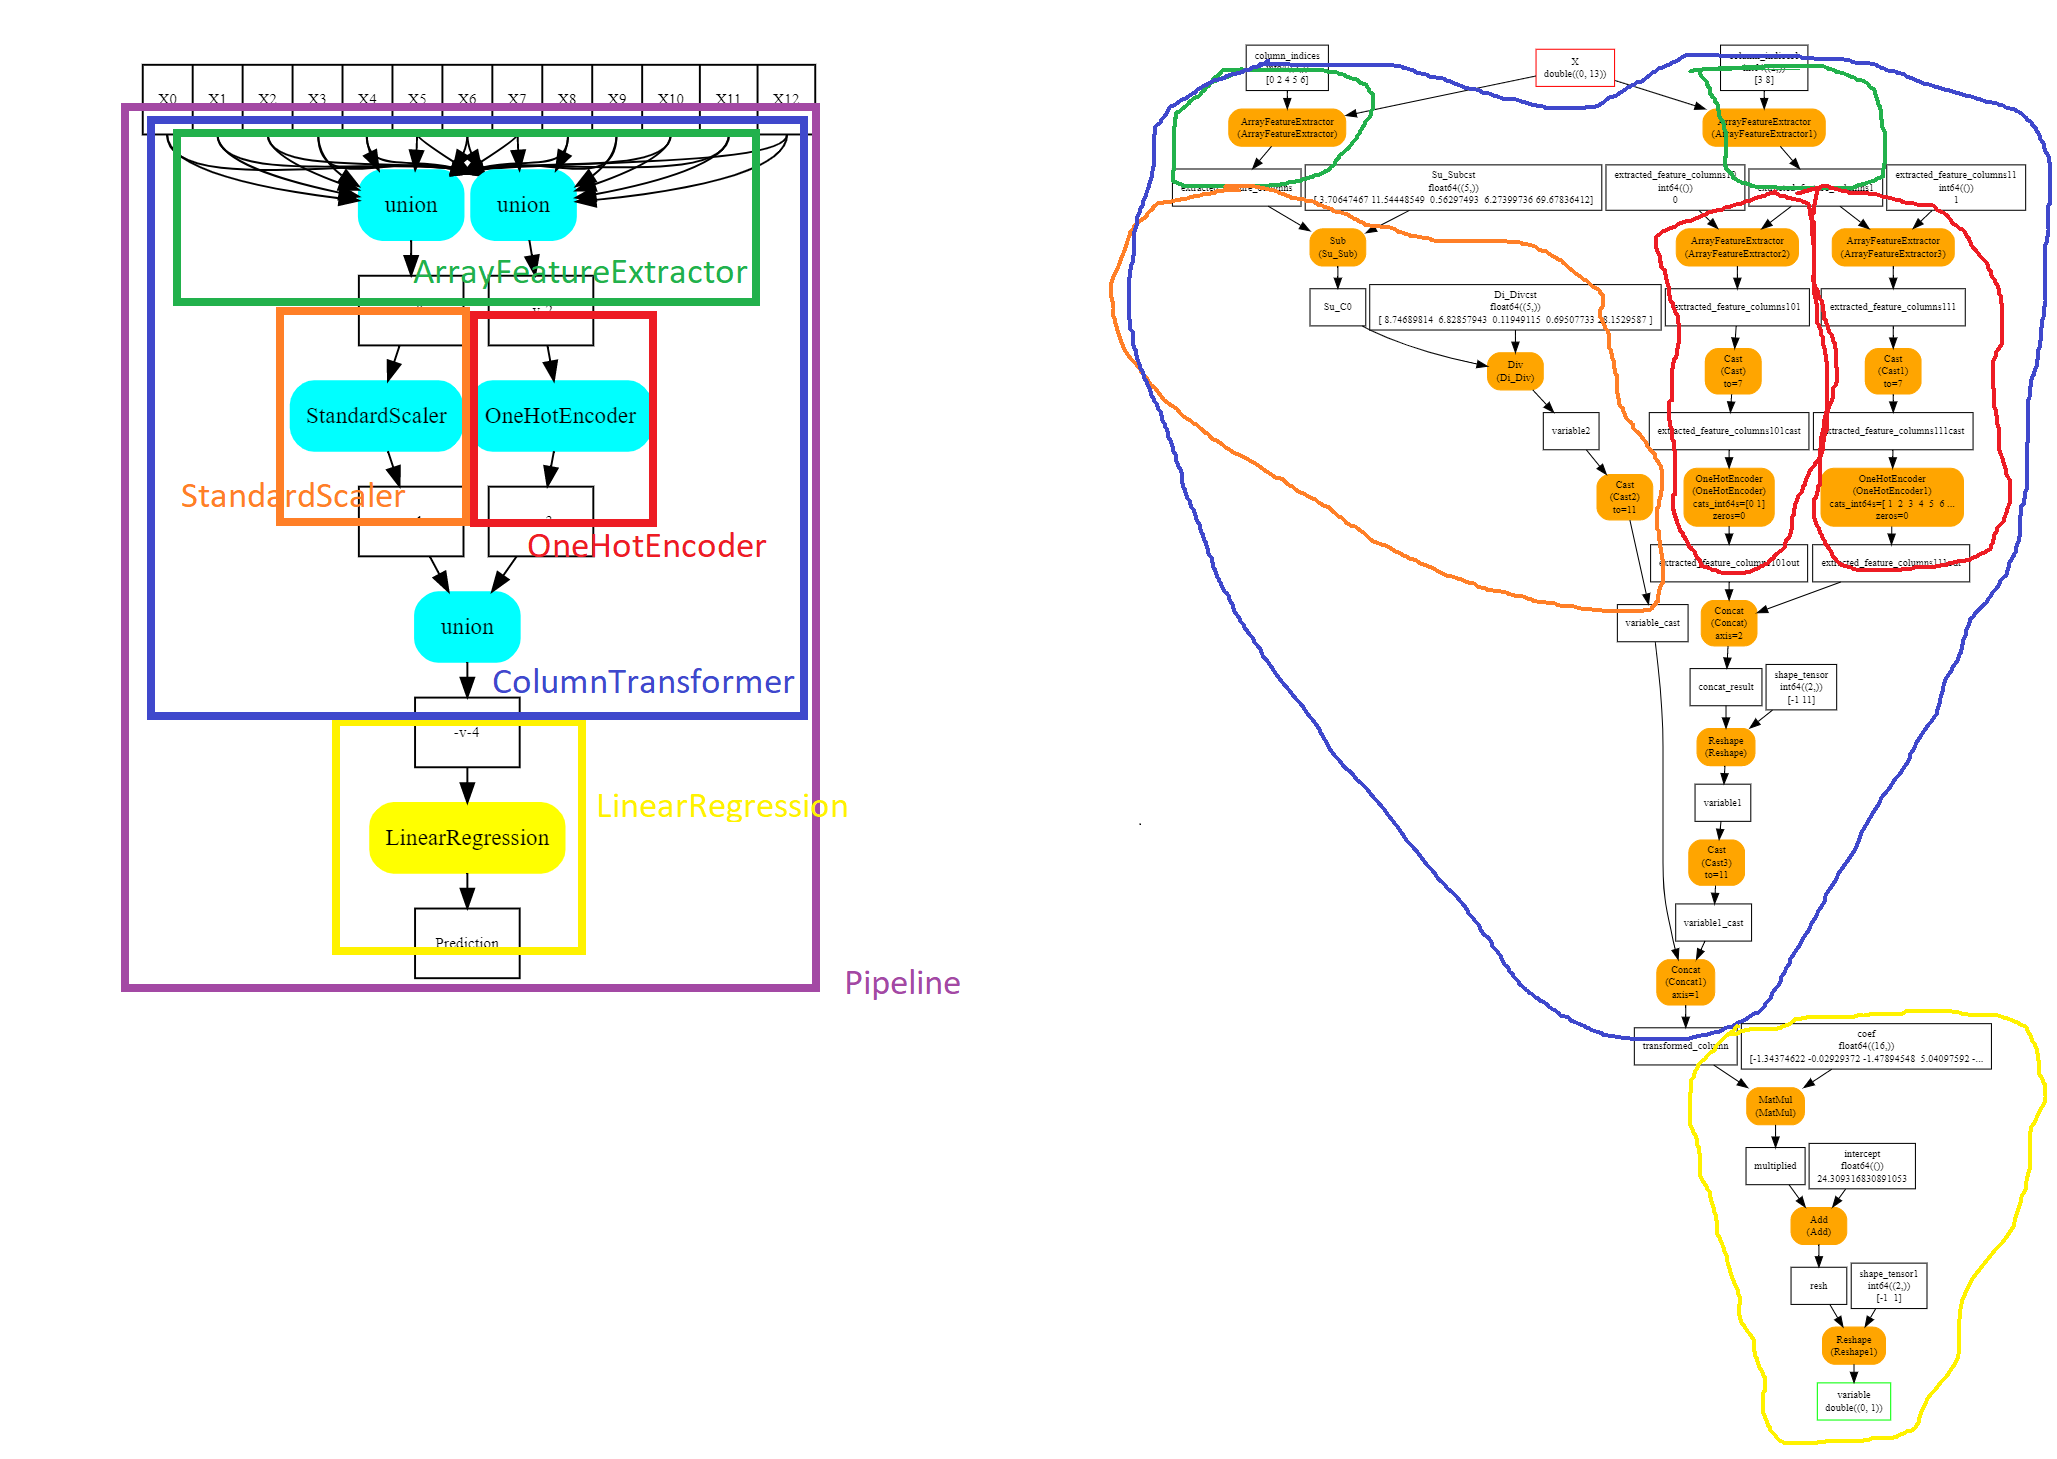

In [18]:
Image('images/pipecolorball.png')

**Some thoughts after playing many hours with converters**

* The three components (parser, shape_calculator, converter) are overcomplex.
* The converter should be the only part needed.
* The code can be simplified without changing the user API.
    * It needs to move the parsing code into the converter (see [_parse_sklearn_pipeline](https://github.com/onnx/sklearn-onnx/blob/master/skl2onnx/_parse.py#L242) and [convert_pipeline](https://github.com/onnx/sklearn-onnx/blob/master/skl2onnx/operator_converters/pipelines.py#L10)).
    * Modify class Topology.

### Package folders

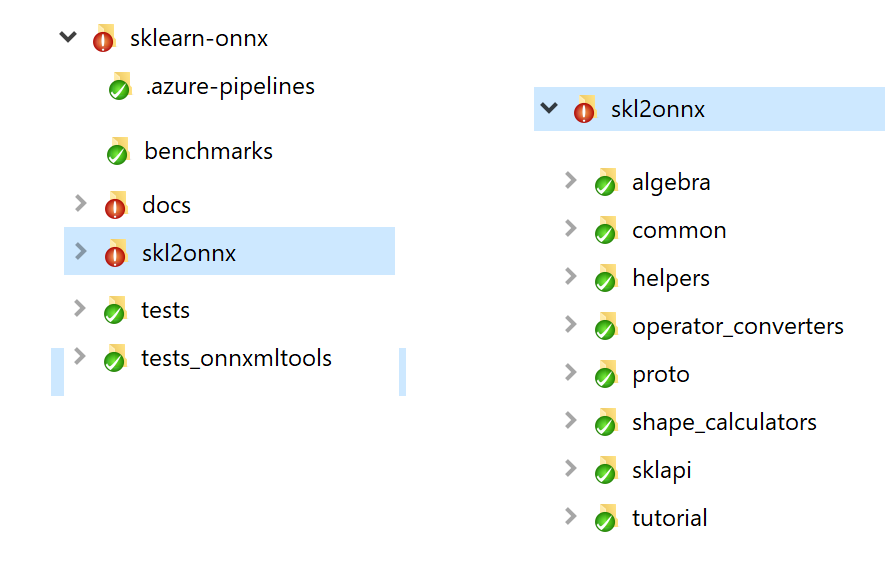

In [19]:
Image('images/folders2.png', width=700)

### Opset, Options

**One model, multiple ONNX graphs**

* Every opset (ONNX version) may change operator signature and introduce new operators.
* Three ways to output probabilities
    * A single tensor ``[N, C]``
    * A list of `N` dictionaries ``{class: probability}`` *(default, historical reasons)*
    * A dictionary ``{class: tensors}`` (requested by a user)

```
to_onnx(model,
        initial_types=...,
        target_opset=14,  # select opset 14 because the 
                          # runtime does not support higher opset
        options={'zipmap': False})  # select single tensor for probabilities
```

**Option for a specific step in the pipeline**

What if an option only applies on one step, one model, one transformer...

```
pipeline = make_pieline(....)

to_onnx(model,
        initial_types=...,
        target_opset=14,  # select opset 14 because the runtime 
                          # does not support higher opset
        options={id(pipeline.steps_[0][1]): {'split': 10}})  # select single tensor for probabilities
```

### Why options? option `optim='cdist'`

* Operator CDist is not an ONNX operator
* It can be implemented by operator [Scan](https://github.com/onnx/onnx/blob/master/docs/Operators.md#Scan)

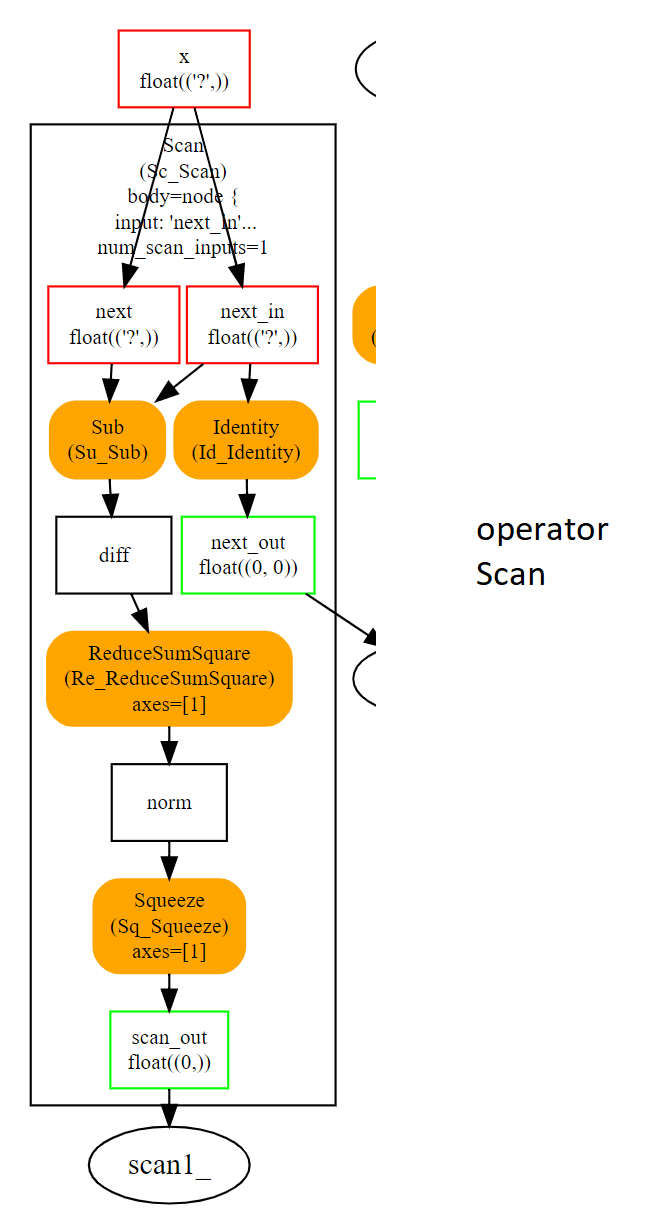

In [20]:
Image("images/cdist.png", width=250)

**CDist vs Scan**

CDist implemented in domain [com.microsoft](https://github.com/microsoft/onnxruntime/blob/master/docs/OperatorKernels.md): much more efficient.

In [21]:
import numpy
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared
from skl2onnx import to_onnx
from onnxruntime import InferenceSession


iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, __ = train_test_split(X, y, random_state=12)
clr = GaussianProcessRegressor(ExpSineSquared(), alpha=20.)
clr.fit(X_train, y_train)

model_onnx = to_onnx(clr, X_train)
model_onnx_cdist = to_onnx(clr, X_train, options={id(clr): {'optim': 'cdist'}})

sess = InferenceSession(model_onnx.SerializeToString())
sess_cdist = InferenceSession(model_onnx_cdist.SerializeToString())

In [22]:
%timeit sess.run(None, {'X': X})

1.67 ms ± 49.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [23]:

%timeit sess_cdist.run(None, {'X': X})

466 µs ± 11.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [24]:
%onnxview model_onnx_cdist --size="8%"

### Main source of discrepancies: float instead of double

* Every ONNX operator supports float, but not double
* Big miss: TreeEnsembleOperator
* Huge discrepancies because stepwise function are not continuous (see [Issues when switching to float](http://onnx.ai/sklearn-onnx/auto_tutorial/plot_ebegin_float_double.html)).

Lightgbm compares double, onnxruntime compares float.

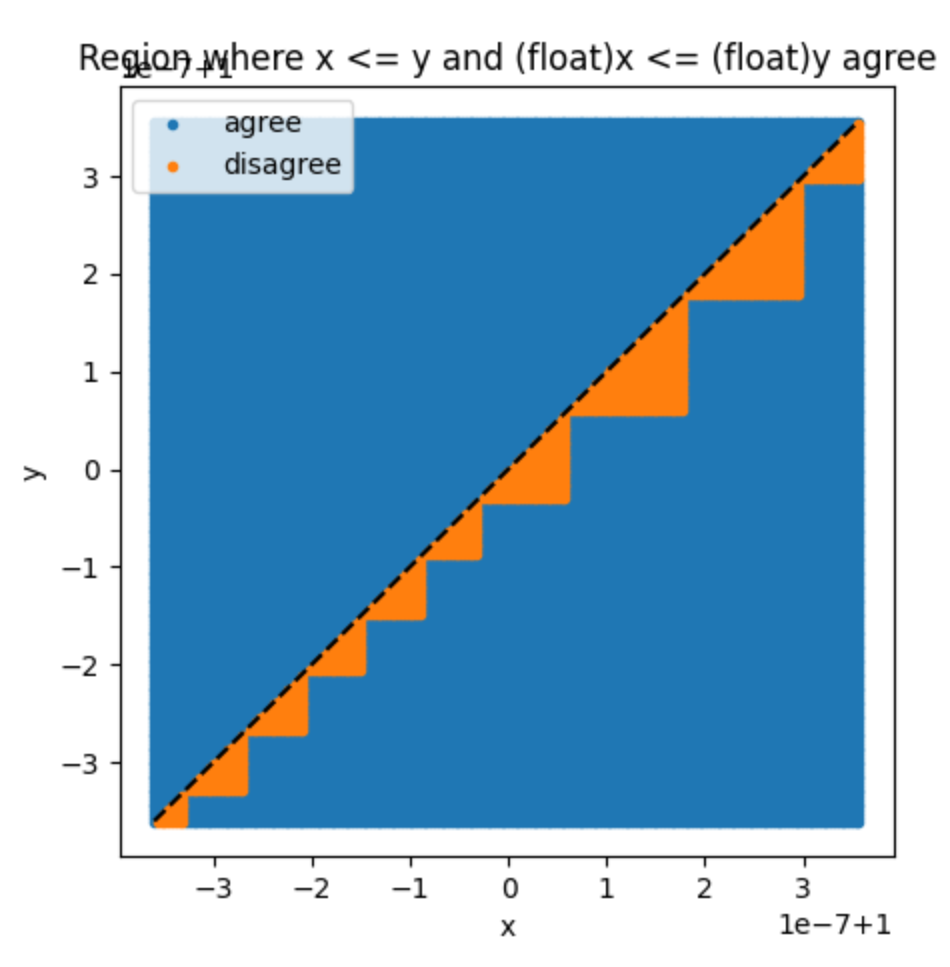

In [25]:
Image('images/double.png', width=400)

**Small discrepancies = distinct decision path**

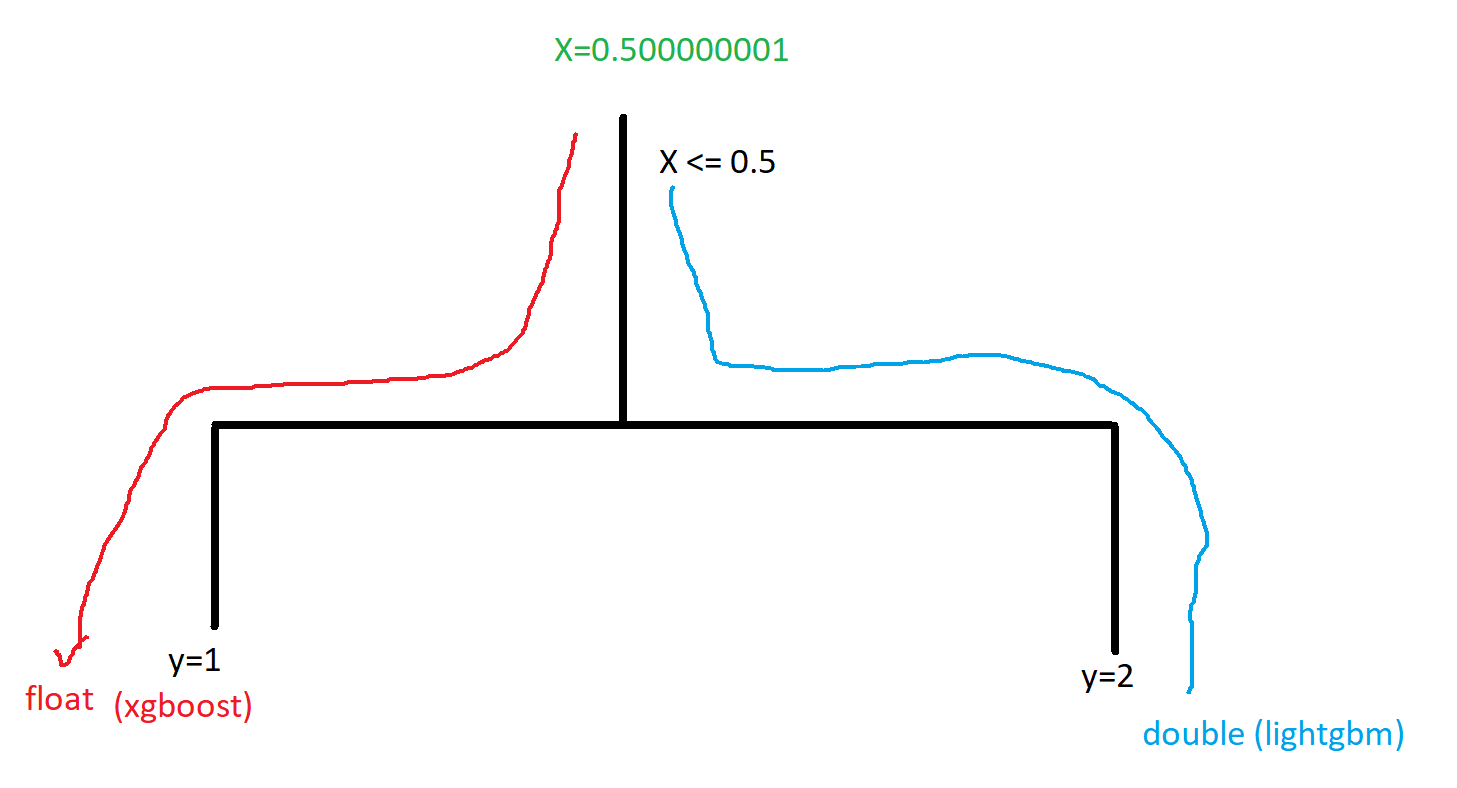

In [26]:
Image("images/stepwise.png", width=500)

**Solution:** compare onnx predictions with lightgbm predictions on **float features** only

**Small discrepencies = random walk for huge forest**

Huge forest = 50.000 trees

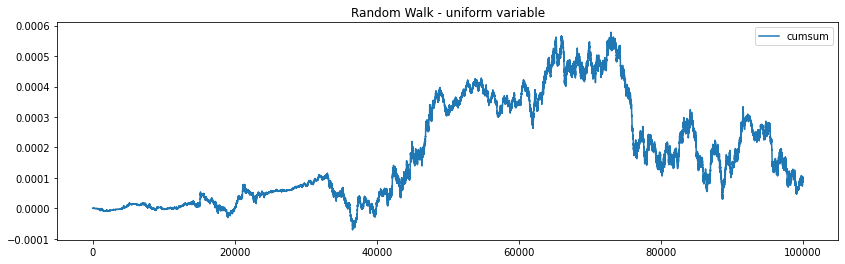

In [27]:
import pandas
rnd = numpy.abs(numpy.random.rand(100000)) - 0.5
c64, c32 = numpy.cumsum(rnd), numpy.cumsum(rnd.astype(numpy.float32))
diff = c64 - c32.astype(numpy.float64)
dfn = pandas.DataFrame(diff)
dfn.columns = ["cumsum"]
dfn.plot(logx=False, logy=False, title="Random Walk - uniform variable", figsize=(14, 4));

**Solution:** split the operator [TreeEnsembleRegressor](https://github.com/onnx/onnx/blob/master/docs/Operators-ml.md#ai.onnx.ml.TreeEnsembleRegressor)

**Split the operator TreeEnsembleRegressor**, then cast the output in double and do the summation with double precision

Regression with 40.000, 200 features, trained with [lightgbm](https://lightgbm.readthedocs.io/en/latest/).

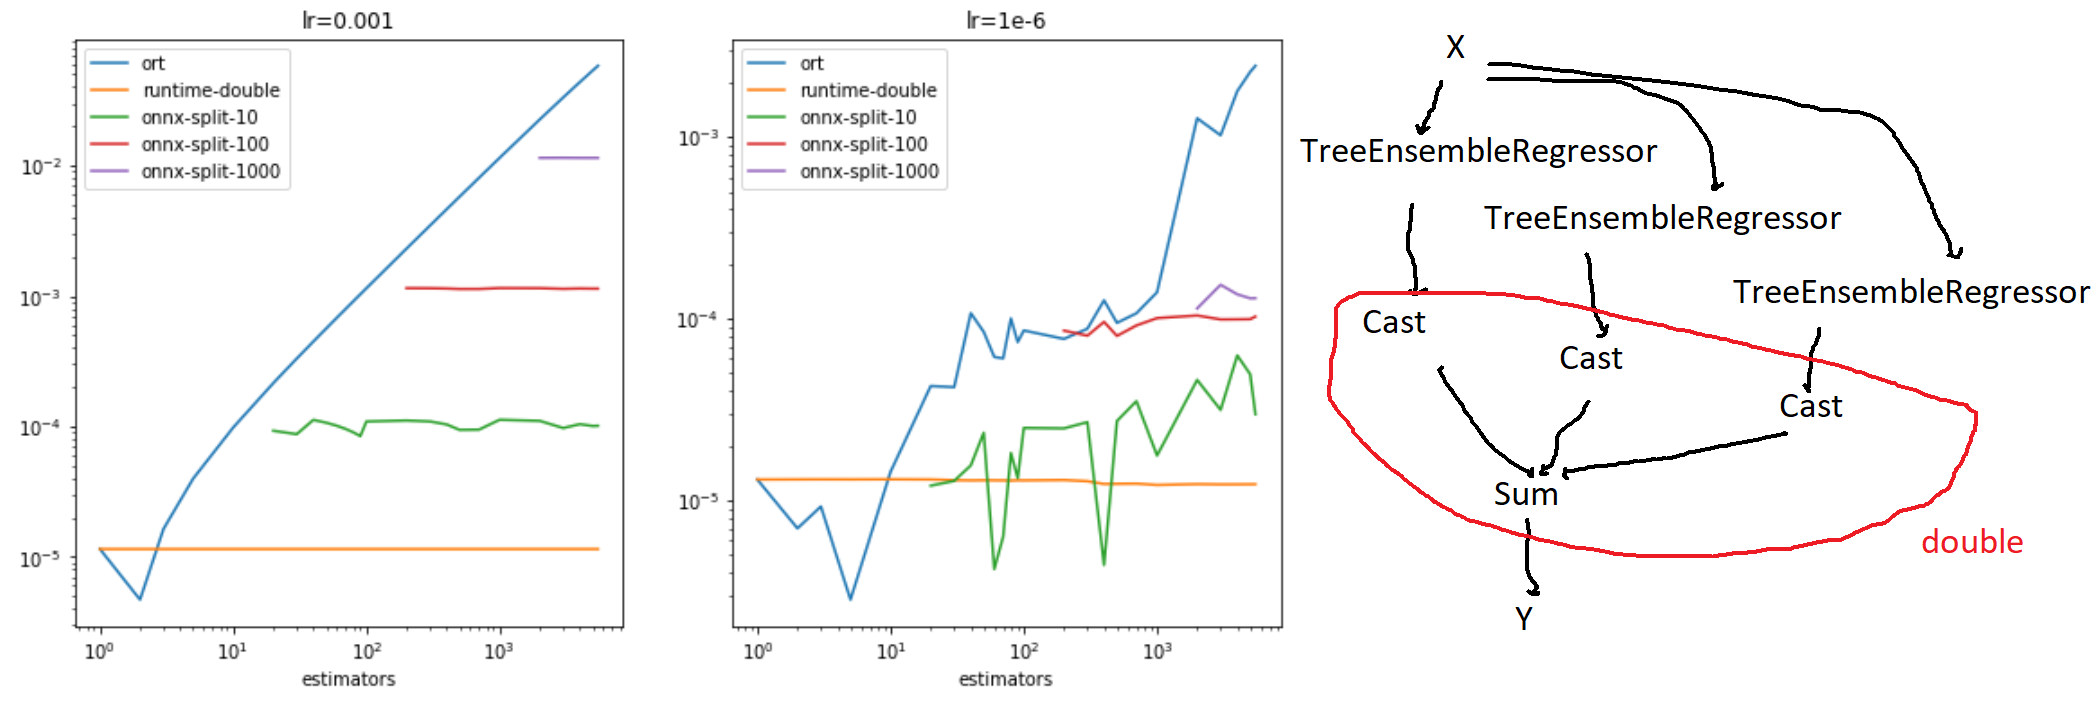

In [28]:
Image('images/treesplit.png')

### Sparse Story

ONNX: Incomplete sparse support

* explicit use of Sparse
    * [SparsePCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html#sklearn.decomposition.SparsePCA)
    * [sparse_coef_](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet.sparse_coef_)
* Dense to Sparse
    * [OneHotEncoder(sparse=True)](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)
    * [TfIdfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer)
    
Once it is sparse, everything which follows must handle sparse as inputs:
    * linear models
    * ensemble

[Combine predictors using stacking](https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html#sphx-glr-auto-examples-ensemble-plot-stack-predictors-py)

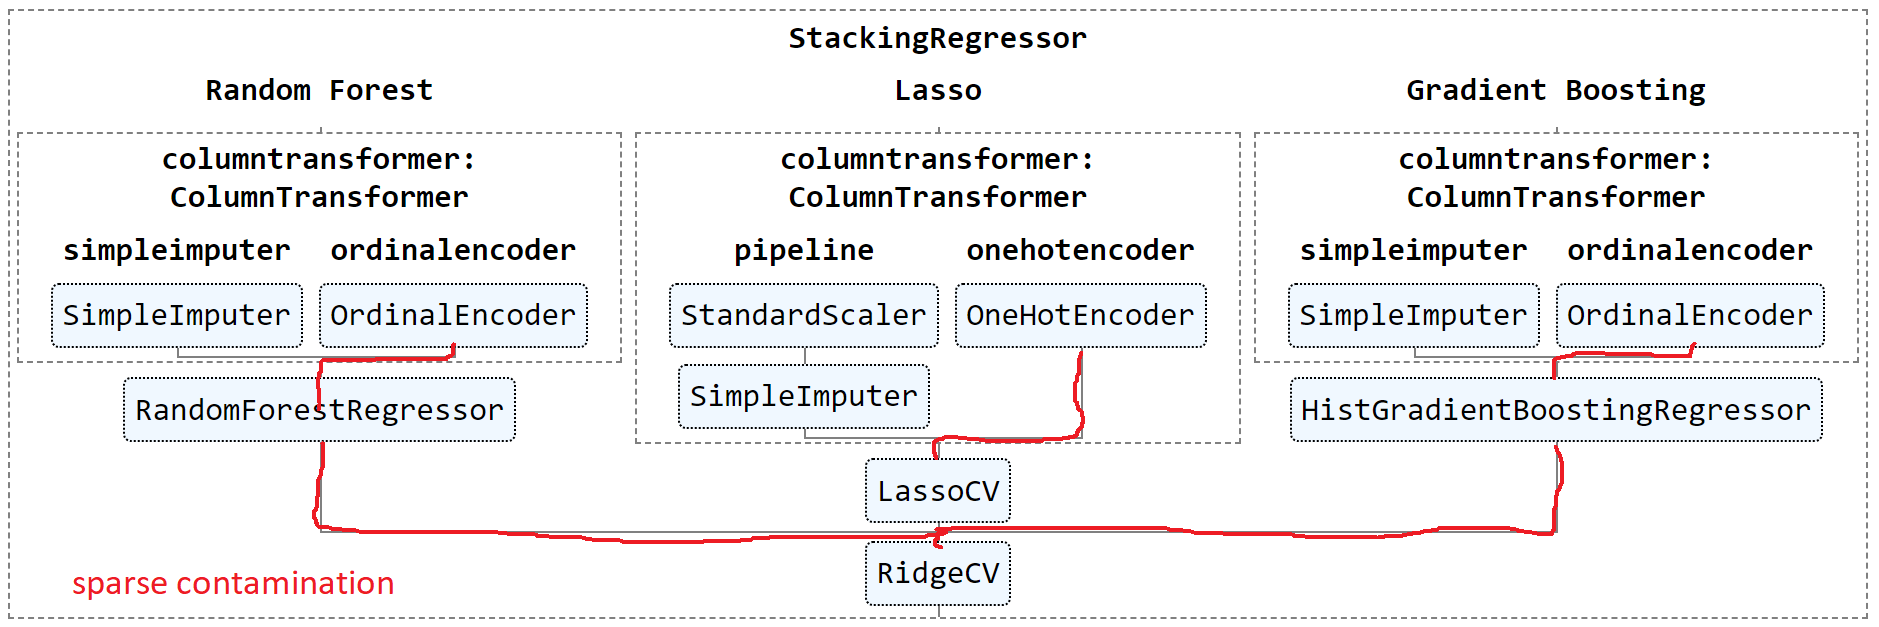

In [29]:
Image('images/pipedoc.png')

## Part 2 : Custom operators, 3 API, and custom code

* Guidelines to add a new converter
* Initial API: verbose
    * 2 years old
    * really verbose with estimators using estimators
    * options, opset
* Second API: much more readable
    * operators as functions
    * easier but still too complex
* Numpy API: python users
    * Users don't want to write converters: too complex.
    * They only know [numpy](https://numpy.org/) and [pandas](https://pandas.pydata.org/).

In [30]:
add_notebook_menu(first_level=2, keep_item=1)

### Guidelines to add a new converter

The best is probably to follow one past PR: [Add converter for KernelPCA](https://github.com/onnx/sklearn-onnx/pull/737).

### Why scikit-learn is more complex than tensorflow?

* [GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)
* [Mixture Models](https://en.wikipedia.org/wiki/Mixture_model)

Formulas... do not always help.

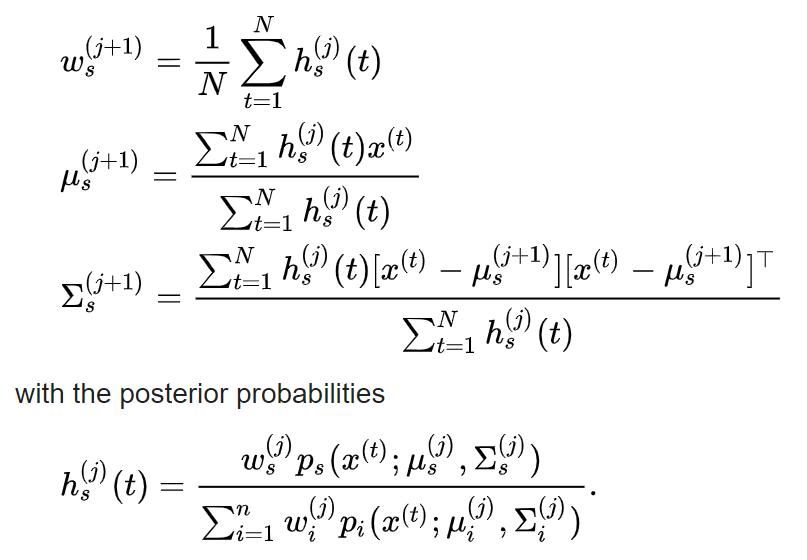

In [31]:
Image("images/gm.png", width=500)

The code is needed and it basically means converting numpy expressions into ONNX.

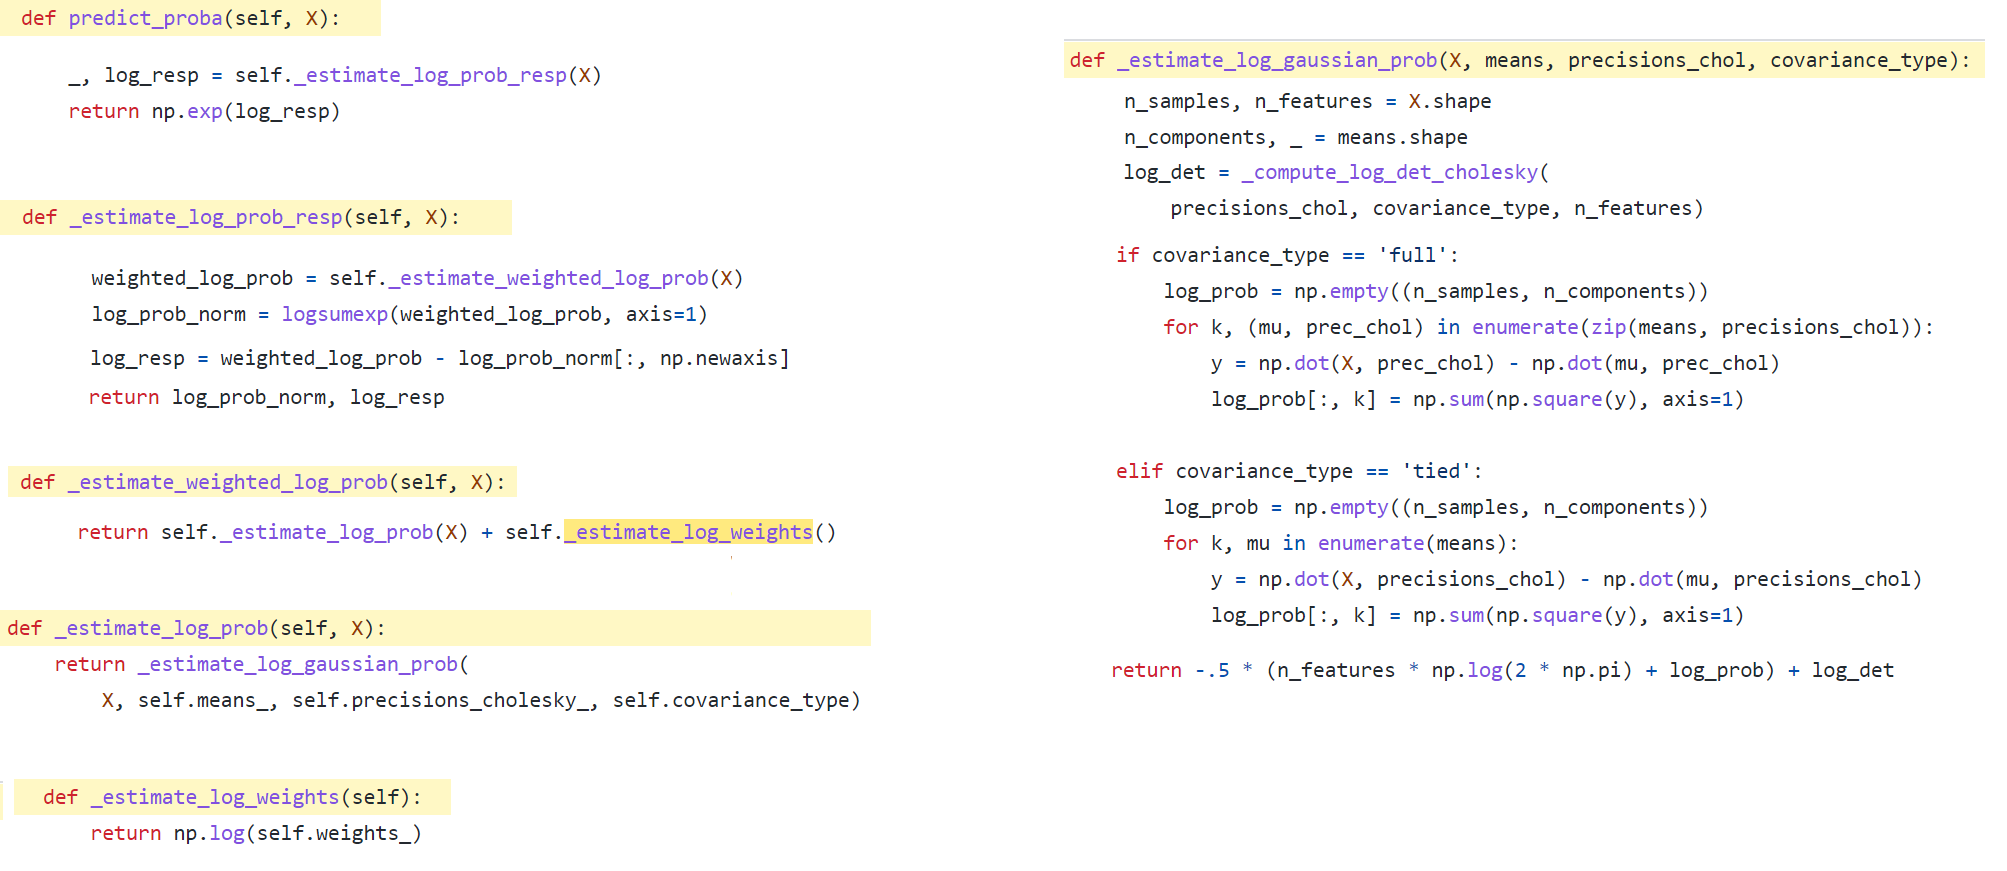

In [32]:
Image("images/codegm.png")

### First API: very close to ONNX API

Class [Container](https://github.com/onnx/sklearn-onnx/blob/master/skl2onnx/common/_container.py#L203). Example: [linear_regressor.py](https://github.com/onnx/sklearn-onnx/blob/master/skl2onnx/operator_converters/linear_regressor.py)

``def add_initializer(self, name, onnx_type, shape, content):``

``def add_node(self, op_type, inputs, outputs, op_domain='', op_version=None, name=None, **attrs):``
 

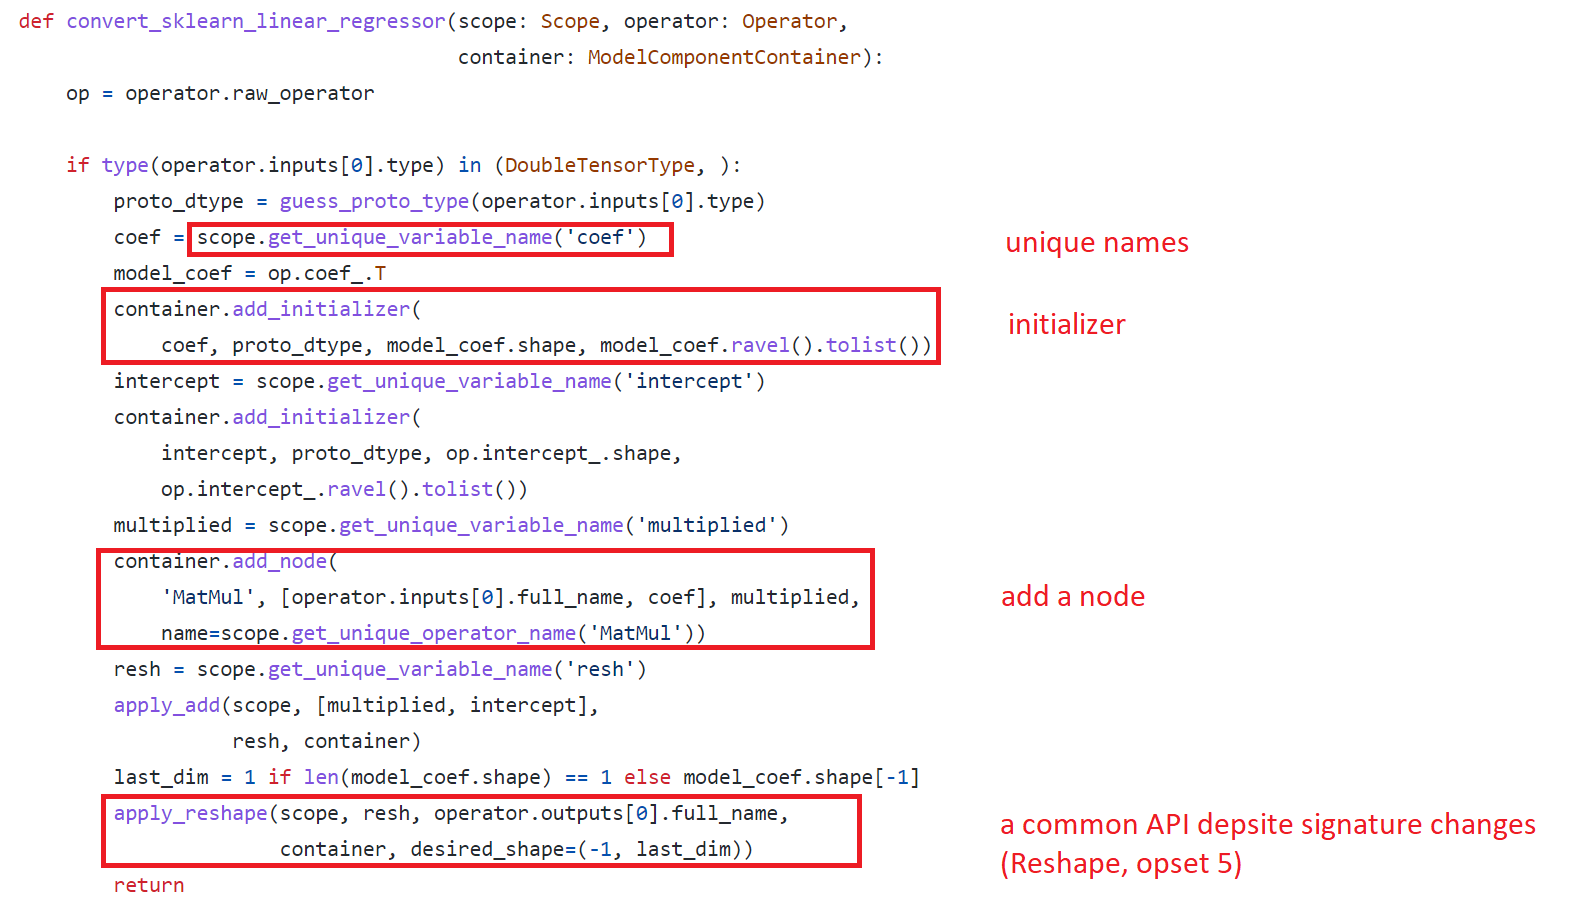

In [33]:
Image("images/linreg.png", width=800)

**First API: major difficulties**

* Developers need to implement python/numpy code with ONNX operators.
* The API is very verbose and hard to read.
* Developers need to write code to convert model in several opsets.
* ONNX is strongly typed, python is not.

### Second API

Simplifies:

* names
* initializers
* adding nodes

Example [k_means.py](https://github.com/onnx/sklearn-onnx/blob/master/skl2onnx/operator_converters/k_means.py)

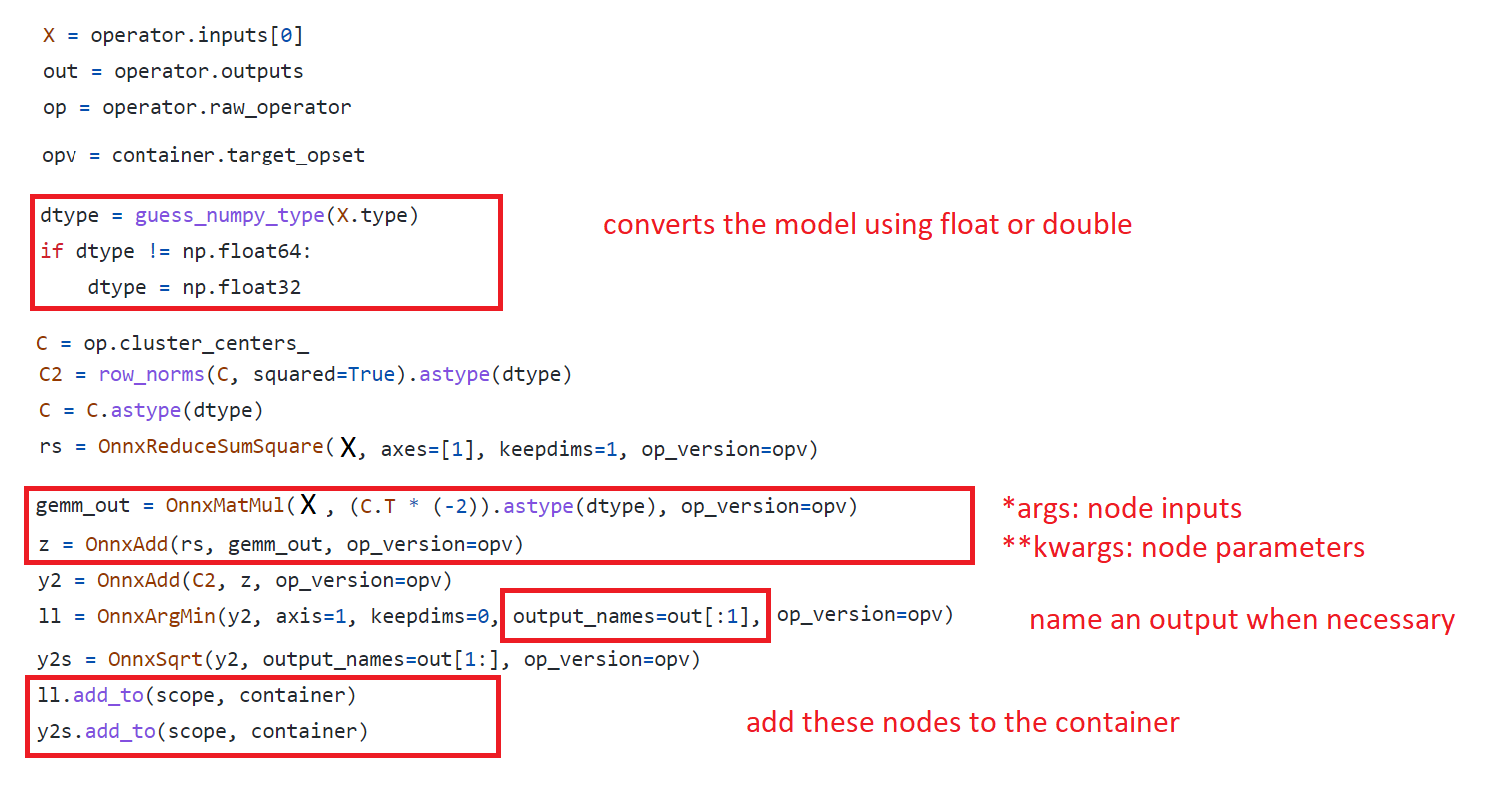

In [34]:
Image("images/kmeans.png", width=800)

One class per operator/opset is dynamically generated based on the installed onnx package. See [Available Onnx Operators](https://onnx.ai/sklearn-onnx/supported.html#available-onnx-operators)

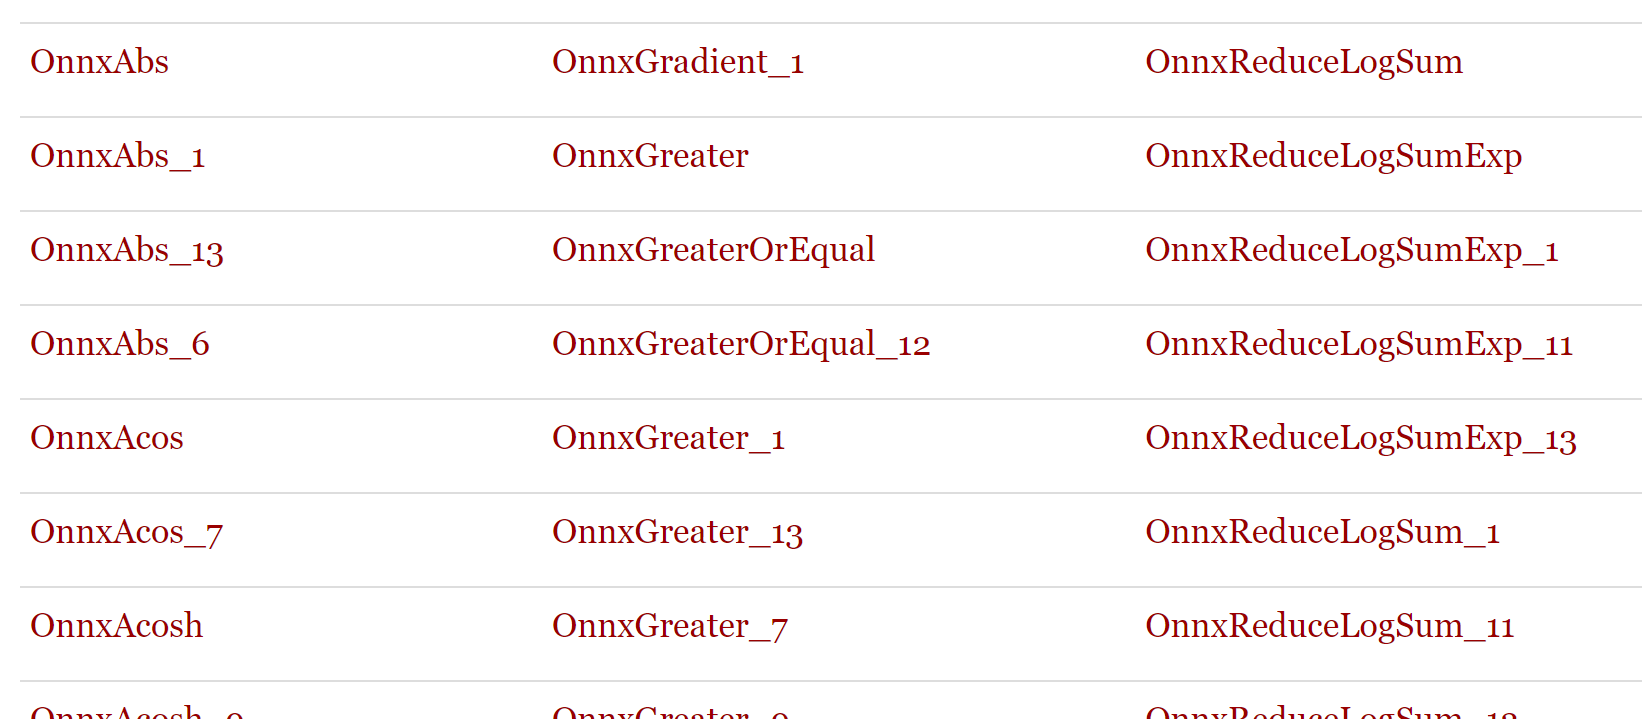

In [35]:
Image("images/onnxops.png", width=600)

**Second API**

Easier to write and read: ``X @ Y.T``

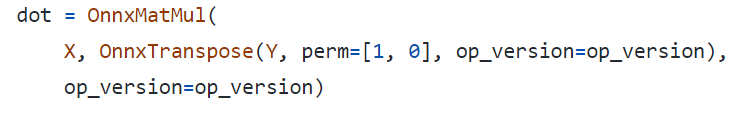

In [36]:
Image('images/op.png')

**Second API: still difficulties**

* Developers need to implement python/numpy code with ONNX operators.
* Developers need to write code to convert model in several opsets.
* ONNX is strongly typed, python is not.

### Experimentation: numpy API for ONNX

Let the developper use onnx without knowning it.

* Implement a method onnx_transform using numpy.
* Use the numpy API to convert that code into ONNX.
* Create a method transform into the class which executes this ONNX with onnxruntime.

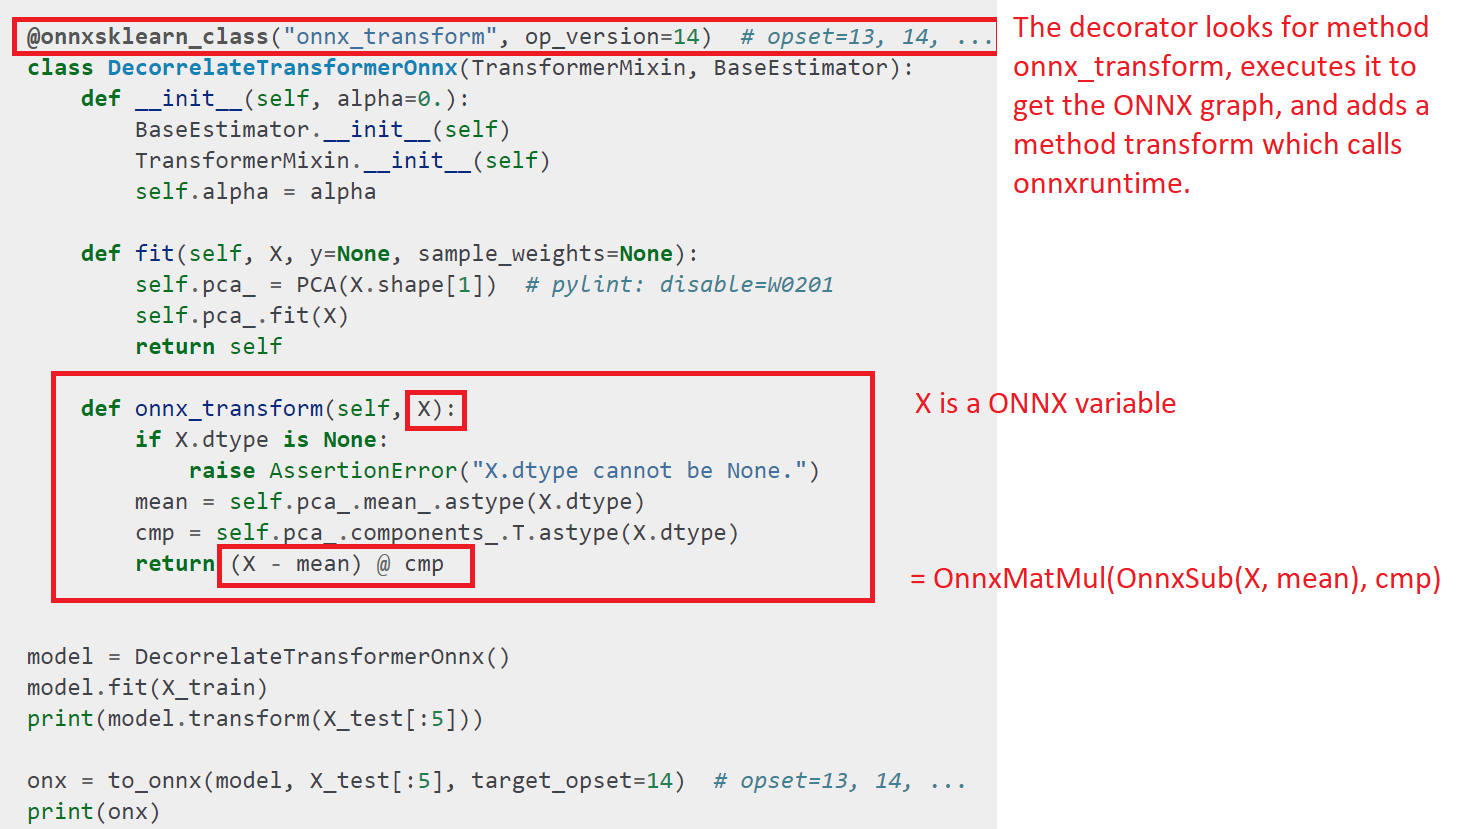

In [37]:
Image('images/numpyapi.png', width=800)

**Third API: less difficulties**

* ONNX is strongly typed, python is not.
* The API does not cover all cases such as loops or tests.
* Error might be hard to understand when the syntax is incorrect.

However:

* This API is much easier to use.
* It reduces dicrepancies as method transform is using ONNX = no discrepancies introduced after conversion since it is the same graph.

### Example with RFFT

In [38]:
from typing import Any
import mlprodict.npy.numpy_onnx_impl as npnx
from mlprodict.npy import onnxnumpy_np
from mlprodict.npy.onnx_numpy_annotation import NDArrayType

def dft_real_cst(N, fft_length):
    n = numpy.arange(N)
    k = n.reshape((N, 1)).astype(numpy.float64)
    M = numpy.exp(-2j * numpy.pi * k * n / fft_length)
    both = numpy.empty((2,) + M.shape)
    both[0, :, :] = numpy.real(M)
    both[1, :, :] = numpy.imag(M)
    return both

@onnxnumpy_np(signature=NDArrayType(("T:all", ), dtypes_out=('T',)))
def onnx_rfft(x, fft_length=None):
    if fft_length is None:
        raise RuntimeError("fft_length must be specified.")

    size = fft_length // 2 + 1
    cst = dft_real_cst(fft_length, fft_length).astype(numpy.float32)
    xt = npnx.transpose(x, (1, 0))
    res = npnx.matmul(cst[:, :, :fft_length], xt[:fft_length])[:, :size, :]
    return npnx.transpose(res, (0, 2, 1))

Results are the same.

In [39]:
rnd = numpy.random.randn(3, 4).astype(numpy.float32)
fft_onx = onnx_rfft(rnd, fft_length=rnd.shape[1])
fft_onx

array([[[-1.7784990e+00,  1.4675100e-01,  2.8697007e+00],
        [ 6.3172030e-01, -2.1366143e-01, -3.2235985e+00],
        [ 5.8288980e-01, -1.9905260e+00, -1.1469542e+00]],

       [[ 0.0000000e+00,  1.6233883e+00,  4.1927758e-16],
        [ 0.0000000e+00,  3.6831067e+00, -1.0557316e-15],
        [ 0.0000000e+00,  4.6142429e-01, -5.9122794e-17]]], dtype=float32)

In [40]:
fft_np = numpy.fft.rfft(rnd)
fft_np

array([[-1.77849905+0.j        ,  0.146751  +1.62338826j,
         2.86970057+0.j        ],
       [ 0.63172024+0.j        , -0.21366143+3.6831066j ,
        -3.22359842+0.j        ],
       [ 0.5828898 +0.j        , -1.99052602+0.46142429j,
        -1.14695418+0.j        ]])

In [41]:
key = list(onnx_rfft.signed_compiled)[0]
onx = onnx_rfft.signed_compiled[key].compiled.onnx_
%onnxview onx --size="8%"

### Three API and subestimators

scikit-learn may build model on the top of other models like VotingRegressor: it trains several predictors of any type and merges the answers.

**First API**

```
    vars_names = []
    for i, estimator in enumerate(op.estimators_):
        if estimator is None:
            continue

        op_type = sklearn_operator_name_map[type(estimator)]

        this_operator = scope.declare_local_operator(op_type, estimator)
        this_operator.inputs = inputs

        var_name = scope.declare_local_variable(
            'var_%d' % i, inputs[0].type.__class__())
        this_operator.outputs.append(var_name)
        var_name = var_name.onnx_name

        if op.weights is not None:
            val = op.weights[i] / op.weights.sum()
        else:
            val = 1. / len(op.estimators_)
```

**Second API**

```
    y_list = [OnnxSubEstimator(sub, inp, op_version=op_version,
                               options=options)
              for sub in op.estimators_]

    # labels
    label_list = [OnnxReshapeApi13(y[0], np.array([-1, 1], dtype=np.int64),
                                   op_version=op_version)
                  for y in y_list]

    label = OnnxConcat(*label_list, axis=1, op_version=op_version,
                       output_names=[operator.outputs[0]])
    label.add_to(scope=scope, container=container)
```

**Third API**

```
    def onnx_graph(self, X):
        h = self.hyperplan_.astype(X.dtype)
        c = self.centers_.astype(X.dtype)

        sign = ((X - c[0]) @ h) >= numpy.array([0], dtype=X.dtype)
        cast = sign.astype(X.dtype).reshape((-1, 1))

        prob0 = nxnpskl.logistic_regression(X, model=self.lr0_)[1]
        prob1 = nxnpskl.logistic_regression(X, model=self.lr1_)[1]

        prob = prob1 * cast - prob0 * (cast - numpy.array([1], dtype=X.dtype))
        label = nxnp.argmax(prob, axis=1)
        return MultiOnnxVar(label, prob)
 ```

## Part 3: challenges and tools

* Challenges
    * Missing converter: [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html), custom code?
    * Sparse
    * Text
* Tools
    * Python Runtime for ONNX
    * Tools to check discrepancies
    * Benchmarks !

In [42]:
add_notebook_menu(first_level=2, keep_item=2)

### Missing converter for custom code

This is a the user code. How to convert that?

In [43]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log1p)
X = np.array([[0, 1], [2, 3]], dtype=float)
transformer.transform(X)

array([[0.        , 0.69314718],
       [1.09861229, 1.38629436]])

In [44]:
from skl2onnx import to_onnx
try:
    to_onnx(transformer, X)
except Exception as e:
    print(e)

FunctionTransformer is not supported unless the transform function is None (= identity). You may raise an issue at https://github.com/onnx/sklearn-onnx/issues.


Currently, the user would have to:

* Create a custom class wrapping the FunctionTransformer.
* Implement a shape_calculator, a converter attached to it.
* Register the converter to skl2onnx.
* Convert the pipeline.

**Sounds quite complex for a simple function ``log1p``.**

But we could use a syntax close to numpy:

In [45]:
import mlprodict.npy.numpy_onnx_pyrt as npnxrt

transformer = FunctionTransformer(npnxrt.log1p)
X = np.array([[0, 1], [2, 3]], dtype=float)
transformer.transform(X)

array([[0.        , 0.69314718],
       [1.09861229, 1.38629436]])

In [46]:
from mlprodict.onnx_conv import to_onnx as to_onnx_extended
onx = to_onnx_extended(transformer, X, rewrite_ops=True)

%onnxview onx --size="8%"

### Sparse

Two cases:

* Categories
* Text (Tfidf)

Both preprocessings are producing many sparse columns.
Sparse becomes dense after conversion. **Two issues:**

* Processing time: much slower
* Confusion between nan and 0: what is a missing value in a sparse matrix? (xgboost and lightgbm disagree)

In [47]:
from sklearn.preprocessing import OneHotEncoder
X = numpy.arange(100).reshape((-1, 1))
ohe = OneHotEncoder(sparse=True).fit(X)
ohe.transform(X)

<100x100 sparse matrix of type '<class 'numpy.float64'>'
	with 100 stored elements in Compressed Sparse Row format>

In [48]:
onx = to_onnx(ohe, X)
%onnxview onx --size="8%"

### Text


* Text processing uses **sparse** most of the time.
* They are often custom: heavily dependent on how the text was produced (lower, upper, remove special characters, ...)
* They use embeddings: glove, word2text, deep learning, ...

What to do?

* [ONNX Zoo](https://github.com/onnx/models/tree/master/text/machine_comprehension)
* New operators for common tokenizers [onnxruntime-extensions/tokenizer](https://github.com/microsoft/onnxruntime-extensions/tree/main/operators/tokenizer)
* Simple text processing [onnxruntime-extensions/text](https://github.com/microsoft/onnxruntime-extensions/tree/main/operators/text)

Back to main problem? How do you write a custom text preprocessing which can be easily converted into ONNX?

### Tools

Developpers usually do not need tool to write converter.

They need tools to check the conversion worked fine.

* A tool to check discrepancies.
* A tool to check processing time.

They would like to access benchmarks too.

**Next:** tools to be agile when implementing converters

### python runtime for ONNX

In [49]:
from sklearn.preprocessing import OneHotEncoder
X = numpy.arange(100).reshape((-1, 1))
ohe = OneHotEncoder(sparse=True).fit(X)
ohe.transform(X)
onx = to_onnx(ohe, X)

In [50]:
from mlprodict.onnxrt import OnnxInference
oinf = OnnxInference(onx)
oinf.run({'X': X})

{'variable': array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)}

Look into intermediate results.

In [51]:
oinf.run({'X': X}, verbose=1, fLOG=print)

-- OnnxInference: run 5 nodes
Onnx-ArrayFeatureExtractor(X, X0) -> X01    (name='ArrayFeatureExtractor')
+kr='X01': (100, 1) (dtype=int32 min=0 max=99)
Onnx-Cast(X01) -> X01cast    (name='Cast')
+kr='X01cast': (100, 1) (dtype=int64 min=0 max=99)
Onnx-OneHotEncoder(X01cast) -> X01out    (name='OneHotEncoder')
+kr='X01out': (100, 1, 100) (dtype=float32 min=0.0 max=1.0)
Onnx-Concat(X01out) -> concat_result    (name='Concat')
+kr='concat_result': (100, 1, 100) (dtype=float32 min=0.0 max=1.0)
Onnx-Reshape(concat_result, shape_tensor) -> variable    (name='Reshape')
+kr='variable': (100, 100) (dtype=float32 min=0.0 max=1.0)


{'variable': array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)}

Look into intermediate results.

In [52]:
oinf.run({'X': X}, verbose=10, fLOG=print)

-kv='X' shape=(100, 1) dtype=int32 min=0 max=99
-kv='X0' shape=() dtype=int64 min=0 max=0
-kv='shape_tensor' shape=(2,) dtype=int64 min=-1 max=100
-- OnnxInference: run 5 nodes
Onnx-ArrayFeatureExtractor(X, X0) -> X01    (name='ArrayFeatureExtractor')
+kr='X01': (100, 1) (dtype=int32 min=0 max=99)
[[ 0]
 [ 1]
 [ 2]
 ...
 [97]
 [98]
 [99]]
Onnx-Cast(X01) -> X01cast    (name='Cast')
+kr='X01cast': (100, 1) (dtype=int64 min=0 max=99)
[[ 0]
 [ 1]
 [ 2]
 ...
 [97]
 [98]
 [99]]
Onnx-OneHotEncoder(X01cast) -> X01out    (name='OneHotEncoder')
+kr='X01out': (100, 1, 100) (dtype=float32 min=0.0 max=1.0)
[[[1. 0. 0. ... 0. 0. 0.]]

 [[0. 1. 0. ... 0. 0. 0.]]

 [[0. 0. 1. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 1. 0. 0.]]

 [[0. 0. 0. ... 0. 1. 0.]]

 [[0. 0. 0. ... 0. 0. 1.]]]
Onnx-Concat(X01out) -> concat_result    (name='Concat')
+kr='concat_result': (100, 1, 100) (dtype=float32 min=0.0 max=1.0)
[[[1. 0. 0. ... 0. 0. 0.]]

 [[0. 1. 0. ... 0. 0. 0.]]

 [[0. 0. 1. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. 

{'variable': array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)}

### Intermediate results inserted into ONNX graph

In [53]:
new_onx = oinf.run2onnx({'X': X})
%onnxview new_onx[1] --size="8%"

### Plot a TreeEnsembleRegressor

In [54]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from mlprodict.plotting.text_plot import onnx_text_plot_tree
data = load_iris()
X, y = data.data.astype(numpy.float32), data.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
model = DecisionTreeRegressor().fit(X_train, y_train)
onx = to_onnx(model, X)

print(onnx_text_plot_tree(onx.graph.node[0]))

n_targets=1
n_trees=1
----
treeid=0
 X2 <= 2.4499998
   F X2 <= 4.95
      F X3 <= 1.75
         F y=2.0 f=0 i=14
         T X3 <= 1.55
            F X2 <= 5.45
               F y=2.0 f=0 i=13
               T y=1.0 f=0 i=12
            T y=2.0 f=0 i=10
      T X3 <= 1.65
         F X1 <= 3.1
            F y=1.0 f=0 i=7
            T y=2.0 f=0 i=6
         T y=1.0 f=0 i=4
   T y=0.0 f=0 i=1


### Export ONNX to numpy code

It does not support all operators yet.

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
data = load_iris()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
model = LogisticRegression().fit(X_train, y_train)
onx = to_onnx(model, X, options={'zipmap': False})

%onnxview onx --size="8%"

In [56]:
from mlprodict.onnx_tools.onnx_export import export2numpy
print(export2numpy(onx))

import numpy
import scipy.special as scipy_special
import scipy.spatial.distance as scipy_distance
from mlprodict.onnx_tools.exports.numpy_helper import (
    argmax_use_numpy_select_last_index,
    argmin_use_numpy_select_last_index,
    array_feature_extrator,
    make_slice)


def numpy_ONNX_LogisticRegression(X):
    '''
    Numpy function for ``ONNX_LogisticRegression``.

    * producer: skl2onnx
    * version: 0
    * description: 
    '''
    # initializers

    list_value = [-0.3820146698920944, 0.3978447755662121, -0.0158301056741248, 0.8896867906595531, -0.14568789790854544, -0.74399889275101, -
                  2.362597473810776, -0.08723543846877874, 2.449832912279553, -0.9319091952800573, -0.8514850826078488, 1.7833942778879046]
    coef = numpy.array(list_value, dtype=numpy.float64).reshape((4, 3))

    intercept = numpy.array([9.111545808820148, 1.675404528603912, -
                            10.786950337424146], dtype=numpy.float64).reshape((1, 3))

    classes = nump

### Export ONNX to tf2onnx code

It does not support all operators yet.

In [57]:
from mlprodict.onnx_tools.onnx_export import export2tf2onnx
print(export2tf2onnx(onx))

import inspect
import collections
import numpy
from onnx import AttributeProto, TensorProto
from onnx.helper import (
    make_model, make_node, set_model_props, make_tensor, make_graph,
    make_tensor_value_info)
# from tf2onnx.utils import make_name, make_sure, map_onnx_to_numpy_type
from mlprodict.onnx_tools.exports.tf2onnx_helper import (
    make_name, make_sure, map_onnx_to_numpy_type)
# from tf2onnx.handler import tf_op
# from tf2onnx.graph_builder import GraphBuilder
from mlprodict.onnx_tools.exports.tf2onnx_helper import (
    tf_op, Tf2OnnxConvert, GraphBuilder)


@tf_op("ONNX_LogisticRegression")
class ConvertONNX_LogisticRegressionOp:

    supported_dtypes = [
        numpy.float32,
    ]

    @classmethod
    def any_version(cls, opset, ctx, node, **kwargs):
        '''
        Converter for ``ONNX_LogisticRegression``.

        * producer: skl2onnx
        * version: 0
        * description: 
        '''
        oldnode = node
        input_name = node.input[0]
        o

### Export to ONNX

In [58]:
from mlprodict.onnx_tools.onnx_export import export2onnx
print(export2onnx(onx))

import numpy
from onnx import numpy_helper, TensorProto
from onnx.helper import (
    make_model, make_node, set_model_props, make_tensor, make_graph,
    make_tensor_value_info)


def create_model():
    '''
    Converted ``ONNX_LogisticRegression``.

    * producer: skl2onnx
    * version: 0
    * description: 
    '''
    # containers
    print('[containers]')   # verbose
    initializers = []
    nodes = []
    inputs = []
    outputs = []

    # opsets
    print('[opsets]')   # verbose
    opsets = {'': 13, 'ai.onnx.ml': 13}
    target_opset = 13

    # initializers
    print('[initializers]')   # verbose

    list_value = [-0.3820146698920944, 0.3978447755662121, -0.0158301056741248, 0.8896867906595531, -0.14568789790854544, -0.74399889275101, -
                  2.362597473810776, -0.08723543846877874, 2.449832912279553, -0.9319091952800573, -0.8514850826078488, 1.7833942778879046]
    value = numpy.array(list_value, dtype=numpy.float64).reshape((4, 3))

    tensor = numpy_helpe

### Plots: compares two implementations

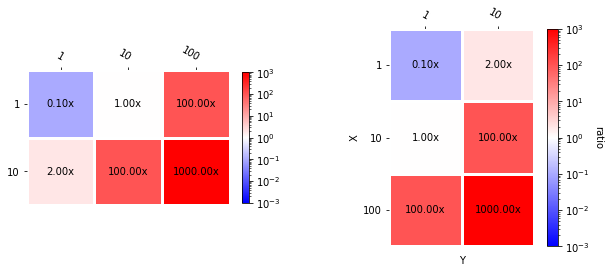

In [59]:
import matplotlib.pyplot as plt
from mlprodict.plotting.plotting_benchmark import plot_benchmark_metrics

data = {(1, 1): 0.1, (10, 1): 1, (1, 10): 2,
        (10, 10): 100, (100, 1): 100, (100, 10): 1000}

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_benchmark_metrics(data, ax=ax[0], cbar_kw={'shrink': 0.6})
plot_benchmark_metrics(data, ax=ax[1], transpose=True,
                       xlabel='X', ylabel='Y',
                       cbarlabel="ratio");

### Plots: compare runtimes

time_kwargs={1: {'number': 100, 'repeat': 100}, 10: {'number': 50, 'repeat': 50}, 100: {'number': 40, 'repeat': 50}, 1000: {'number': 40, 'repeat': 40}, 10000: {'number': 20, 'repeat': 20}}
[enumerate_validated_operator_opsets] opset in [14, None].


LinearRegression            :   0%|                                                              | 0/2 [00:00<?, ?it/s]

[enumerate_compatible_opset] opset in [14, None].


DecisionTreeRegressor       :  50%|███████████████████████████                           | 1/2 [00:32<00:32, 32.95s/it]

[enumerate_compatible_opset] opset in [14, None].


DecisionTreeRegressor       : 100%|██████████████████████████████████████████████████████| 2/2 [00:48<00:00, 24.21s/it]


Saving raw_data into 'data.csv'.
Saving summary into 'summary.csv'.
Saving graph into 'bench.png'.


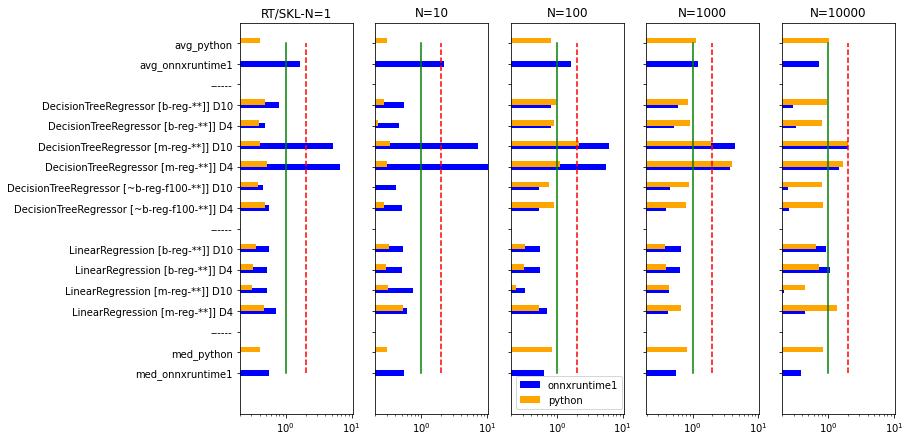

In [60]:
from mlprodict.cli import validate_runtime

validate_runtime(
    verbose=1,
    out_raw="data.csv", out_summary="summary.csv",
    benchmark=True, dump_folder="dump_errors",
    runtime=['python', 'onnxruntime1'],
    models=['LinearRegression', 'DecisionTreeRegressor'],
    n_features=[4, 10], dtype="32",
    out_graph="bench.png",
    time_kwargs={
        1: {"number": 100, "repeat": 100}, 10: {"number": 50, "repeat": 50},
        100: {"number": 40, "repeat": 50}, 1000: {"number": 40, "repeat": 40},
        10000: {"number": 20, "repeat": 20}})

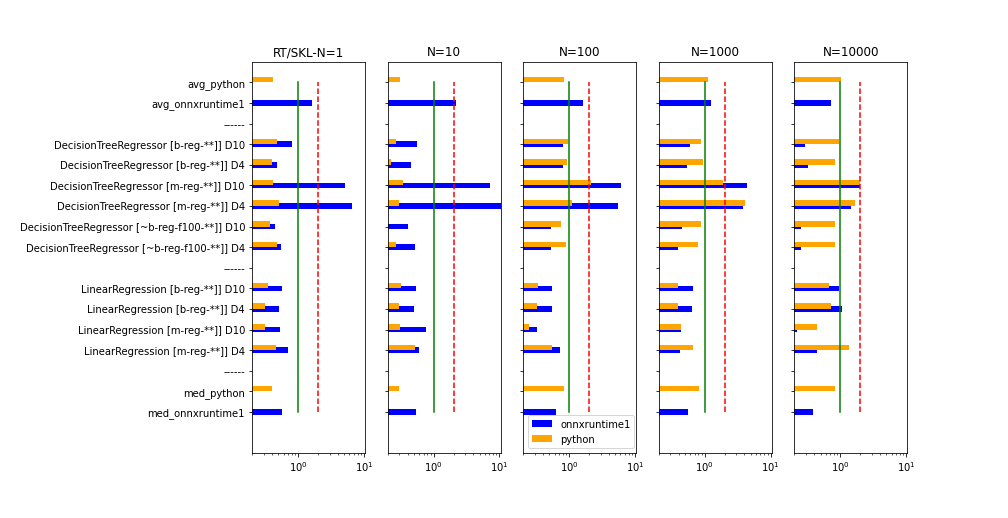

In [61]:
Image('bench.png')

### Modifies ONNX graph

In [62]:
from mlprodict.onnx_tools.onnx_manipulations import select_model_inputs_outputs

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
data = load_iris()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
model = LogisticRegression().fit(X_train, y_train)
onx = to_onnx(model, X, options={'zipmap': False})

%onnxview onx --size="8%"

In [63]:
simple_onx = select_model_inputs_outputs(onx, outputs=['raw_scores'], infer_shapes=True)
%onnxview simple_onx --size="8%"

### Merges two ONNX: OnnxTransformer

In [64]:
import os
from pyensae.datasource import download_data

src = ("https://s3.amazonaws.com/onnx-model-zoo/mobilenet/"
       "mobilenetv2-1.0/")
model_file = "mobilenetv2-1.0.onnx"
src = "https://s3.amazonaws.com/onnx-model-zoo/squeezenet/squeezenet1.1/"
model_file = "squeezenet1.1.onnx"

if not os.path.exists(model_file):
    print("Download '{0}'...".format(model_file))
    download_data(model_file, website=src)
    print("Done.")

In [65]:
import numpy
from PIL import Image as PILImage


def preprocess(img):
    img2 = img.resize((224, 224))
    X = numpy.asarray(img2).transpose((2, 0, 1))
    X = X[numpy.newaxis, :3, :, :] / 255.0
    return X.astype(numpy.float32)

url = "https://github.com/sdpython/mlprodict/raw/master/_doc/notebooks/"
img_path = "800px-Tour_Eiffel_Wikimedia_Commons_(cropped).jpg"
download_data(img_path, website=url)
image = PILImage.open(img_path)
image.reduce(4)

image_data = preprocess(image)
image_data.shape, image_data.min(), image_data.max()

((1, 3, 224, 224), 0.0, 0.9843137)

In [66]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from mlprodict.sklapi import OnnxTransformer

with open(model_file, 'rb') as f: content = f.read()

pipe = Pipeline([
    ('squeeze', OnnxTransformer(content, runtime='onnxruntime1')),
    ('scaler', Normalizer(norm='l1'))])
pipe.fit(image_data)
onx_pred = pipe.transform(image_data)
onx_pred[0, :5]

array([0.00053482, 0.00035403, 0.00059171, 0.00070281, 0.0005738 ],
      dtype=float32)

In [67]:
onx = to_onnx(pipe, image_data)
with open("squeeze_norm.onnx", "wb") as f:
    f.write(onx.SerializeToString())

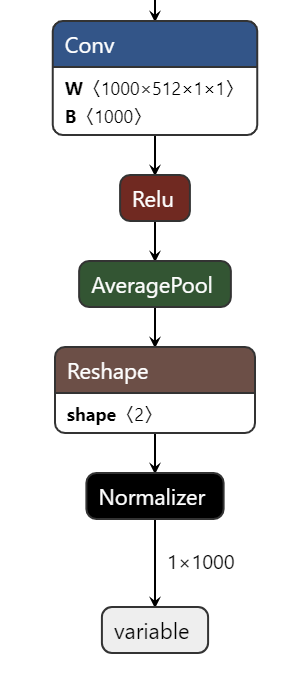

In [68]:
Image("images/sqsc.png", width=150)

### Speed up a scikit-learn step

In [69]:
import numpy
from numpy.testing import assert_almost_equal
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.decomposition import PCA
from pyquickhelper.pycode.profiling import profile
from mlprodict.sklapi import OnnxSpeedupTransformer
from mlprodict.tools.speed_measure import measure_time

data, _ = make_regression(1000, n_features=20)
data = data.astype(numpy.float64)
model = PCA(n_components=10).fit(data)

model_ort = OnnxSpeedupTransformer(PCA(n_components=10), runtime='onnxruntime1').fit(data)

assert_almost_equal(model.transform(data), model_ort.transform(data), decimal=6)

In [70]:
%timeit model.transform(data)

147 µs ± 26.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [71]:
%timeit model_ort.transform(data)

127 µs ± 11.8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Other tools

* TreeEnsembleRegressorDouble, SvmRegressorDouble: to investigate discrepancies
* Custom operators: Solve
* Benchmark with [asv](https://github.com/airspeed-velocity/asv)
* Distances between two ONNX graphs (not yet complete)
* Did you say Einsum? [Einsum Decomposition](http://www.xavierdupre.fr/app/mlprodict/helpsphinx/notebooks/einsum_decomposition.html) or [FFT](http://www.xavierdupre.fr/app/mlprodict/helpsphinx/notebooks/onnx_fft.html#onnxfftrst)
* OnnxComplexAbs: to check implementation with FFT

**Operator calls done with python script**

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
data = load_iris()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
model = LogisticRegression().fit(X_train, y_train)
onx = to_onnx(model, X, options={'zipmap': False})
oinf = OnnxInference(onx, runtime="python_compiled")
print(oinf._run_compiled_code)

def compiled_run(dict_inputs):
    # init: classes (classes)
    # init: coef (coef)
    # init: intercept (intercept)
    # init: shape_tensor (shape_tensor)
    # inputs
    X = dict_inputs['X']
    (multiplied, ) = n0_matmul(X, coef)
    (raw_scores, ) = n1_add(multiplied, intercept)
    (label1, ) = n2_argmax_12(raw_scores)
    (probabilities, ) = n3_softmax(raw_scores)
    (array_feature_extractor_result, ) = n4_arrayfeatureextractor(classes, label1)
    (cast2_result, ) = n5_cast(array_feature_extractor_result)
    (reshaped_result, ) = n6_reshape_13(cast2_result, shape_tensor)
    (label, ) = n7_cast(reshaped_result)
    return {
        'label': label,
        'probabilities': probabilities,
    }


## Questions...